In [ ]:
!pip install git+https://github.com/taylanot/GPy.git

  Cloning https://github.com/taylanot/GPy.git to /tmp/pip-req-build-9yb5x2ha
  Running command git clone -q https://github.com/taylanot/GPy.git /tmp/pip-req-build-9yb5x2ha
     |████████████████████████████████| 71 kB 3.7 MB/s 
  Created wheel for GPy: filename=GPy-1.9.9-cp37-cp37m-linux_x86_64.whl size=3500545 sha256=952b88e3fcfed54a45055dbbc6c0dc9af64f5f5e9beb12abefd7238e9376aaf6
  Stored in directory: /tmp/pip-ephem-wheel-cache-tjwkekqa/wheels/61/f5/53/b781b924ea735e9e2d8aa3d93adccd52a9ab6a6cd42a81b2e1
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102565 sha256=1df55272da4f07e40cfcdd2e3ecf4dc4bd6ad8b48449d027a6b486717d8fd1d0
  Stored in directory: /root/.cache/pip/wheels/c8/95/f5/ce28482da28162e6028c4b3a32c41d147395825b3cd62bc810
Successfully built GPy paramz


**This Part is for the Recursive Linear Multi-fidelity Regression** 

Some reasons to utilize recursive formulation:
* Avoid a Big covariance matrix inversion 


reconstraining parameters fidelity_m_2_m_multiGP.rbf.lengthscale
reconstraining parameters fidelity_m_1_m_GP.rbf.lengthscale



Name : fidelity-1-GP
Objective : 102.307899615692
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  fidelity_m_1_m_GP.       |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        

Name : fidelity-2-multiGP
Objective : 126.95203687791198
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  fidelity_m_2_m_multiGP.  |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        

Model : multiGP
Number of fidelities : 2
Scaling Parameters : [0.3528084806911098]
Optimization restart 1/100, f = 29.949751722075682
Optimization restart 2/100, f = 20.978683822804815
Optimization restart 

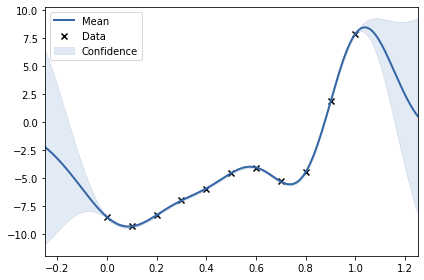

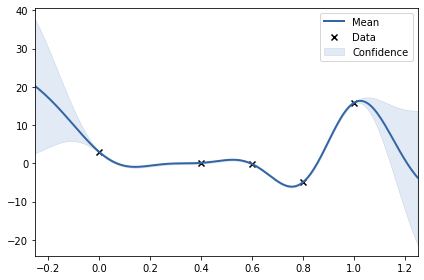

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import GPy.models
np.random.seed(24)
################################################################################
# Expensive Function
def fe(x):
    return (6.0*x-2.)**2*np.sin(12*x-4)
# Cheap Function
def fc(x):
    A = 0.5; B=10; C=5
    return A*fe(x) + B*(x-0.5) - C
################################################################################

x  = np.linspace(0,1,100).reshape(-1,1)                   # Some Uniform Test Points
Xl  =   np.linspace(0,1,11).reshape(-1,1)                 # Low-fidelity Training Data Feature
Xh  =   np.array([0,0.4,0.6,0.8,1]).reshape(-1,1)         # High-fidelity Training Data Feature
X   =   [Xl,Xh]                                           # Store Training Data Features [low->high]
Yl  =   fc(Xl)                                            # Get Low-fidelity Labels
Yh  =   fe(Xh)                                            # Get High-fidelity Labels
Y   =   [Yl,Yh]                                           # Store Training Data Labels [low->high]

# Initialize model
m   =   GPy.models.multiGPRegression(X,Y)                 
print(m)                                                  # Print Model Information 
## In object m there lives two Gaussian Processes now one for low fidelity and one for high fidelity with RBF kernel in obth fidelities
## The models are stored in an array as [low->high] 

# Might fix the noise-terms on both fidelities [Extra Assumption?]
#m.models[0]['Gaussian_noise.variance'].fix(1.e-6)        # Fix High-fidelity noise
#m.models[1]['Gaussian_noise.variance'].fix(1.e-6)        # Fix Low-fidelity noise


# Might want to constrain some hyper-parameters if you know how your data and assumptions will effect your model [Extra Assumption?]
m.models[0]['.*lengthscale'].constrain_bounded(0.1,1)   
m.models[1]['.*lengthscale'].constrain_bounded(0.1,1)

# Optimize hyper-parameters with given training data 
# m.optimize_restarts(restarts=100)                      # First optimize low-fidelity then optimize high-fidelity

# These two lines below do the exact same thing as the m.optimize_restarts(restarts=100)
m.models[0].optimize_restarts(num_restarts=100)
m.models[1].optimize_restarts(num_restarts=100)

print(m)                                                 # Print model information 
m.plot()                                                 # Plot the all fidelities [low->high] only valid for 1D problems
